<h1>Mumbai Housing Price Prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
import scipy.stats 
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)
from sklearn.preprocessing import LabelEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df1 = pd.read_csv("/kaggle/input/mumbai-house-prices/Mumbai House Prices.csv")

df1.head()

,bhk,type,locality,area,price,price_unit,region,status,age
0,3,Apartment,Lak And Hanware The Residency Tower,685,2.50,Cr,Andheri West,Ready to move,New
1,2,Apartment,Radheya Sai Enclave Building No 2,640,52.51,L,Naigaon East,Under Construction,New
2,2,Apartment,Romell Serene,610,1.73,Cr,Borivali West,Under Construction,New
3,2,Apartment,Soundlines Codename Urban Rainforest,876,59.98,L,Panvel,Under Construction,New
4,2,Apartment,Origin Oriana,659,94.11,L,Mira Road East,Under Construction,New


In [3]:
df1.shape

(76038, 9)

<h2> Understanding the dataset

In [4]:
df1.describe()

,bhk,area,price
count,76038.000000,76038.000000,76038.00000
mean,2.015111,1024.536850,29.38227
std,0.922754,670.276165,32.90345
min,1.000000,127.000000,1.00000
25%,1.000000,640.000000,1.75000
50%,2.000000,872.000000,5.50000
75%,3.000000,1179.000000,59.00000
max,10.000000,16000.000000,99.99000


In [5]:
df1['region'].value_counts()

Thane West         14868
Mira Road East      9902
Dombivali           3041
Kandivali East      2568
Kharghar            2362
                   ...  
Police Colony          1
GTB Nagar              1
Bandra                 1
Sector 14 Vashi        1
Goregaon               1
Name: region, Length: 228, dtype: int64

In [6]:
df1['type'].value_counts()

Apartment            74854
Studio Apartment       882
Villa                  226
Independent House       73
Penthouse                3
Name: type, dtype: int64

In [7]:
df1['age'].value_counts()

New        38072
Resale     23357
Unknown    14609
Name: age, dtype: int64

<h2>Data Preprocessing

In [8]:
df1.isnull().sum()

bhk           0
type          0
locality      0
area          0
price         0
price_unit    0
region        0
status        0
age           0
dtype: int64

No missing data phew!

In [9]:
df1['status'].unique()

array(['Ready to move', 'Under Construction'], dtype=object)

Dropping features that are not required to make our model predictions: <b>age, locality and status</b> 

In [10]:
df2 = df1.drop(['age', 'locality', 'status'], axis=1)
df2.head()

,bhk,type,area,price,price_unit,region
0,3,Apartment,685,2.50,Cr,Andheri West
1,2,Apartment,640,52.51,L,Naigaon East
2,2,Apartment,610,1.73,Cr,Borivali West
3,2,Apartment,876,59.98,L,Panvel
4,2,Apartment,659,94.11,L,Mira Road East


In [11]:
df2.columns

Index(['bhk', 'type', 'area', 'price', 'price_unit', 'region'], dtype='object')

In [12]:
df2['bhk'].unique()

array([ 3,  2,  5,  1,  4,  6,  9,  8, 10,  7])

<h3> Response Variable

In [13]:
conversion_factor_crore_to_lakh = 100  # 1 Crore = 100 Lakhs

def convert_to_lakhs(row):
    if row["price_unit"] == "L":
        return row["price"]
    elif row["price_unit"] == "Cr":
        return row["price"] * conversion_factor_crore_to_lakh

df2["price_lakhs"] = df2.apply(convert_to_lakhs, axis=1)

df3 = df2.drop(['price', 'price_unit'], axis=1)
df3.head()

,bhk,type,area,region,price_lakhs
0,3,Apartment,685,Andheri West,250.00
1,2,Apartment,640,Naigaon East,52.51
2,2,Apartment,610,Borivali West,173.00
3,2,Apartment,876,Panvel,59.98
4,2,Apartment,659,Mira Road East,94.11


<h3>Log Transform

/tmp/ipykernel_20/259957056.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df3['price_lakhs'])


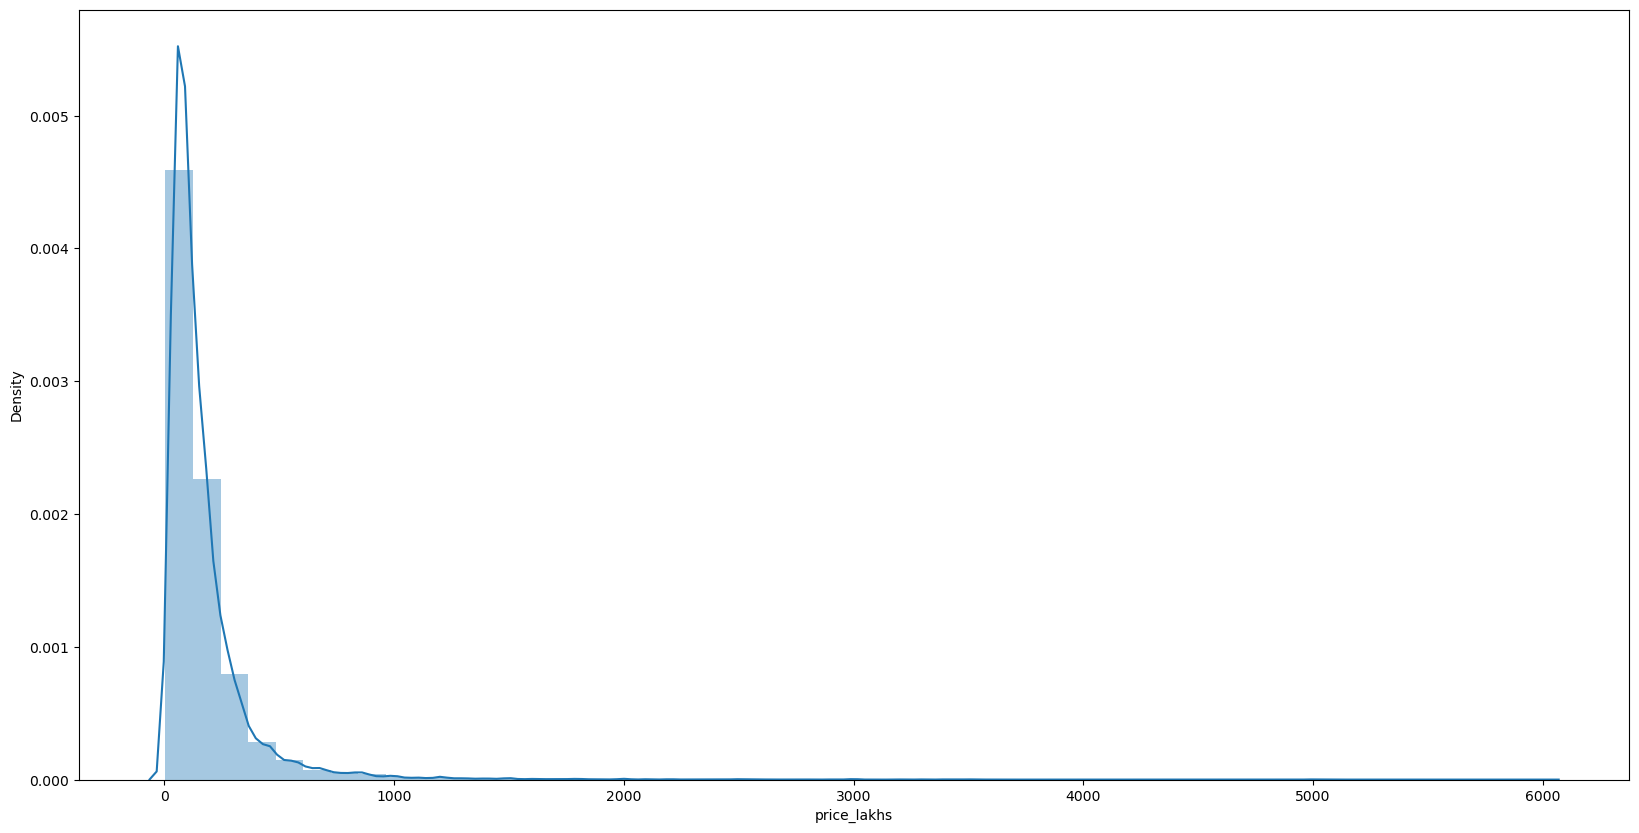

In [14]:
ax = sns.distplot(df3['price_lakhs'])

In [15]:
log_transform_y =  np.log(df3['price_lakhs'])

/tmp/ipykernel_20/956796254.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(log_transform_y)


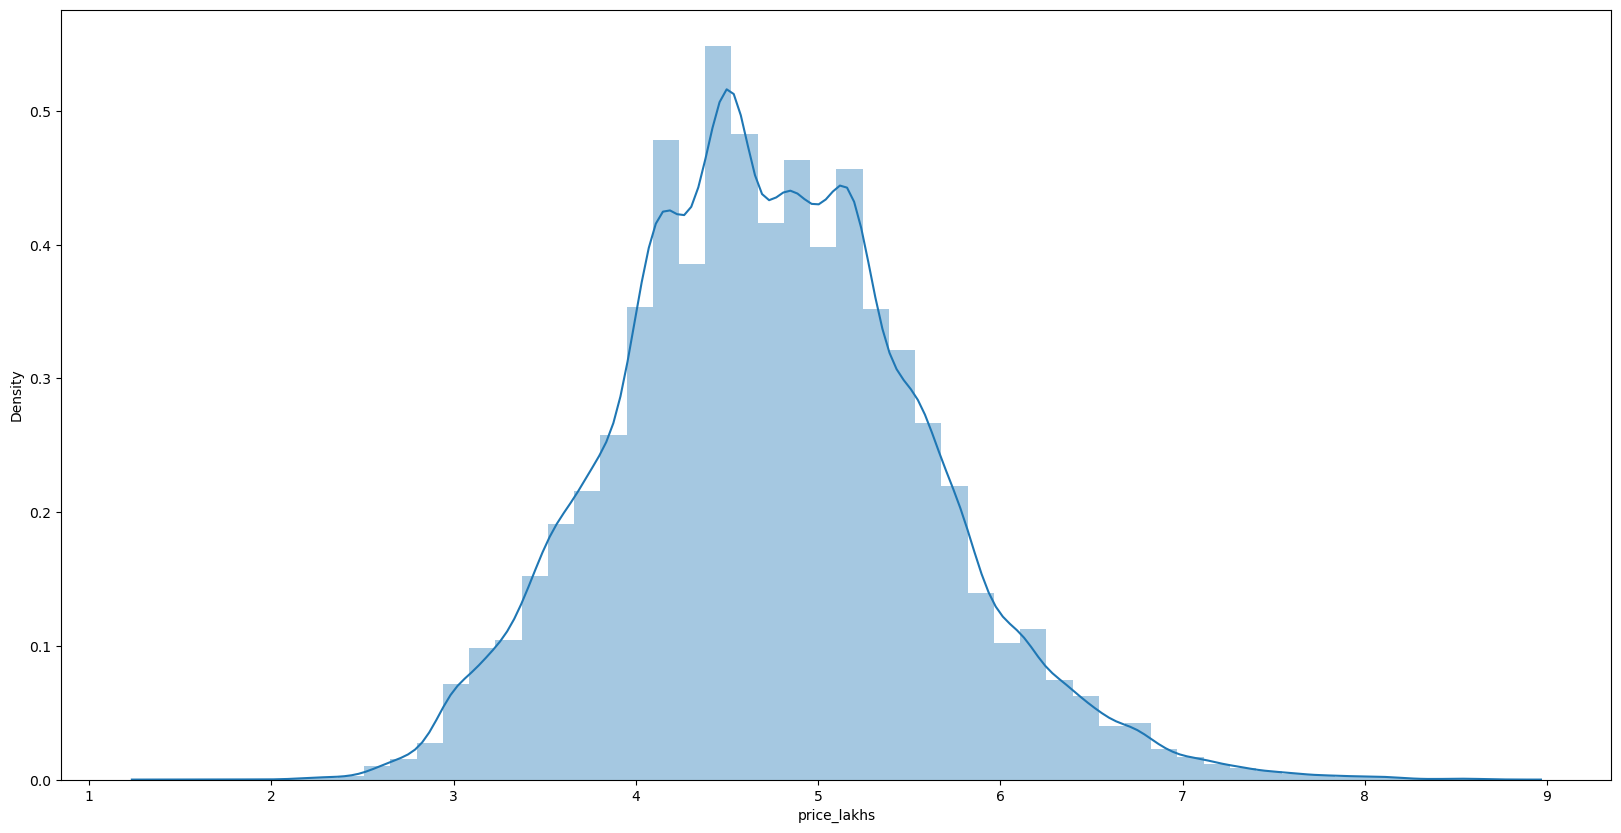

In [16]:
ax = sns.distplot(log_transform_y)

<h3> Adding a new feature Price per sqft

In [17]:
df4 = df3.copy()
df4['price_per_sqft'] = df4['price_lakhs']/df4['area']
df4.head()

,bhk,type,area,region,price_lakhs,price_per_sqft
0,3,Apartment,685,Andheri West,250.00,0.364964
1,2,Apartment,640,Naigaon East,52.51,0.082047
2,2,Apartment,610,Borivali West,173.00,0.283607
3,2,Apartment,876,Panvel,59.98,0.068470
4,2,Apartment,659,Mira Road East,94.11,0.142807


In [18]:
df4['price_per_sqft'].describe()

count    76038.000000
mean         0.151188
std          0.093329
min          0.006468
25%          0.085714
50%          0.130000
75%          0.194961
max          1.823077
Name: price_per_sqft, dtype: float64

<h3>Numerical and Categorical Features

In [19]:
numerical_features = df4[['bhk', 'area', 'price_lakhs', 'price_per_sqft']]
categorical_features = df4.select_dtypes(include=['object'])

<h3>Box-Plots for Numerical Features to detect Outliers

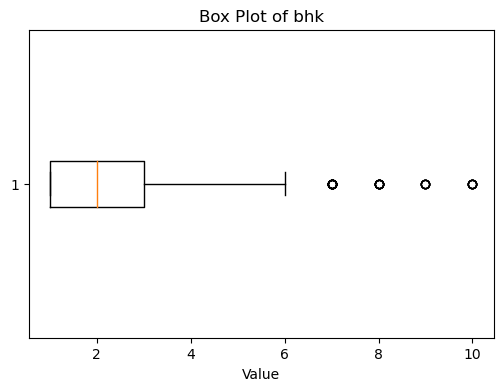

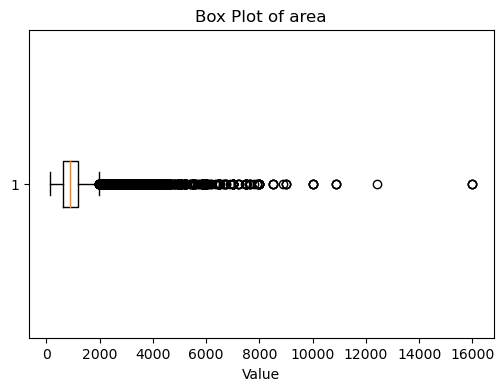

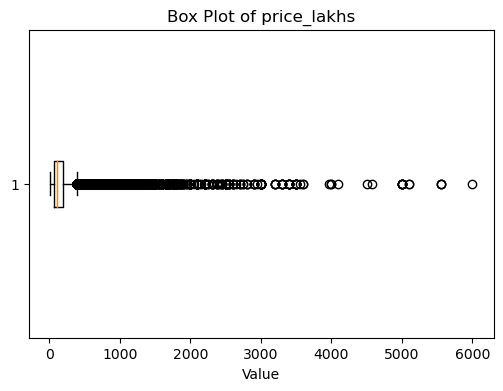

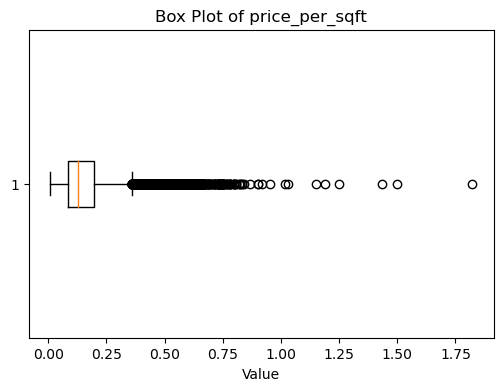

In [20]:
for i, column in enumerate(numerical_features.columns):
    plt.figure(figsize=(6, 4))
    plt.boxplot(df4[column], vert=False, boxprops=dict())
    plt.title(f'Box Plot of {column}')
    plt.xlabel('Value')
    plt.show()

<h3>Standardizing the numerical features

In [21]:
scaler = StandardScaler()

standardized_features = scaler.fit_transform(numerical_features)

std_df4 = pd.DataFrame(standardized_features, columns=numerical_features.columns)
std_df4.head()

,bhk,area,price_lakhs,price_per_sqft
0,1.067343,-0.506566,0.374808,2.290572
1,-0.016376,-0.573703,-0.532508,-0.740838
2,-0.016376,-0.618461,0.021052,1.418844
3,-0.016376,-0.221607,-0.498189,-0.886309
4,-0.016376,-0.545356,-0.341387,-0.089799


Correlation Matrix for the numerical variables

In [22]:
std_df4.corr()

,bhk,area,price_lakhs,price_per_sqft
bhk,1.000000,0.787738,0.631353,0.362950
area,0.787738,1.000000,0.756000,0.216128
price_lakhs,0.631353,0.756000,1.000000,0.664473
price_per_sqft,0.362950,0.216128,0.664473,1.000000


Concatinating with the categorical features

In [23]:
std_df5 = pd.concat([std_df4, categorical_features], axis=1)
std_df5.head()

,bhk,area,price_lakhs,price_per_sqft,type,region
0,1.067343,-0.506566,0.374808,2.290572,Apartment,Andheri West
1,-0.016376,-0.573703,-0.532508,-0.740838,Apartment,Naigaon East
2,-0.016376,-0.618461,0.021052,1.418844,Apartment,Borivali West
3,-0.016376,-0.221607,-0.498189,-0.886309,Apartment,Panvel
4,-0.016376,-0.545356,-0.341387,-0.089799,Apartment,Mira Road East


<h2> Dimensionality Reduction

<h3>Examine region which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [24]:
std_df5.region = std_df5.region.apply(lambda x: x.strip())
location_stats = std_df5['region'].value_counts(ascending=False)
location_stats

Thane West         14868
Mira Road East      9902
Dombivali           3041
Kandivali East      2568
Kharghar            2362
                   ...  
Police Colony          1
GTB Nagar              1
Bandra                 1
Sector 14 Vashi        1
Goregaon               1
Name: region, Length: 228, dtype: int64

In [25]:
location_stats.values.sum()

76038

In [26]:
len(location_stats[location_stats>10])

114

In [27]:
len(location_stats[location_stats<=10])

114

In [28]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Kanjurmarg East      10
Vasind               10
Sector 20 Kamothe    10
Koproli              10
Cuffe Parade          9
                     ..
Police Colony         1
GTB Nagar             1
Bandra                1
Sector 14 Vashi       1
Goregaon              1
Name: region, Length: 114, dtype: int64

In [29]:
len(std_df5.region.unique())

228

In [30]:
std_df5.region = std_df5.region.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df4.region.unique())

228

In [31]:
std_df5.region.value_counts()

Thane West           14868
Mira Road East        9902
Dombivali             3041
Kandivali East        2568
Kharghar              2362
                     ...  
Sector 21 Kamothe       16
Kalwa                   15
Nalasopara East         15
Vangani                 13
Saphale                 12
Name: region, Length: 115, dtype: int64

shifting the response variable to the end of df

In [32]:
target_col = 'price_lakhs'
std_df5 = std_df5[[col for col in std_df5.columns if col != target_col] + [target_col]]
std_df5.head()

,bhk,area,price_per_sqft,type,region,price_lakhs
0,1.067343,-0.506566,2.290572,Apartment,Andheri West,0.374808
1,-0.016376,-0.573703,-0.740838,Apartment,Naigaon East,-0.532508
2,-0.016376,-0.618461,1.418844,Apartment,Borivali West,0.021052
3,-0.016376,-0.221607,-0.886309,Apartment,Panvel,-0.498189
4,-0.016376,-0.545356,-0.089799,Apartment,Mira Road East,-0.341387


<h3>One Hot Encoding of Categorical Variables : type, region

Type

In [33]:
df5 = std_df5.copy()
df5 = pd.get_dummies(df5, columns=['type'], prefix=['type'])
df5.head()

,bhk,area,price_per_sqft,region,price_lakhs,type_Apartment,type_Independent House,type_Penthouse,type_Studio Apartment,type_Villa
0,1.067343,-0.506566,2.290572,Andheri West,0.374808,1,0,0,0,0
1,-0.016376,-0.573703,-0.740838,Naigaon East,-0.532508,1,0,0,0,0
2,-0.016376,-0.618461,1.418844,Borivali West,0.021052,1,0,0,0,0
3,-0.016376,-0.221607,-0.886309,Panvel,-0.498189,1,0,0,0,0
4,-0.016376,-0.545356,-0.089799,Mira Road East,-0.341387,1,0,0,0,0


Region

In [34]:
df_encoded = pd.get_dummies(df5, columns=['region'], prefix=['region'])

In [35]:
df_encoded.head()

,bhk,area,price_per_sqft,price_lakhs,type_Apartment,type_Independent House,type_Penthouse,type_Studio Apartment,type_Villa,region_Agripada,...,region_Vasai,region_Vashi,region_Vikhroli,region_Ville Parle East,region_Ville Parle West,region_Virar,region_Virar West,region_Wadala,region_Worli,region_other
0,1.067343,-0.506566,2.290572,0.374808,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.016376,-0.573703,-0.740838,-0.532508,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.016376,-0.618461,1.418844,0.021052,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.016376,-0.221607,-0.886309,-0.498189,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.016376,-0.545356,-0.089799,-0.341387,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df_encoded.shape

(76038, 124)

<h3> Preparing to model the data

In [37]:
X = df_encoded.drop('price_lakhs', axis=1)
y = log_transform_y

<h3> Fitting OLS model for interpretation

In [38]:
# Add a constant to the X_scaled matrix for intercept term
X_scaled = sm.add_constant(X)

model = sm.OLS(y, X_scaled).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            price_lakhs   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                 1.105e+04
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        14:49:43   Log-Likelihood:                 16317.
No. Observations:               76038   AIC:                        -3.239e+04
Df Residuals:                   75916   BIC:                        -3.126e+04
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

According to the R-squared, 87.9% of the variance in the dependent variable is explained by the model. Initial Rsquared was 87.9%, it increased as i log transformed the response variable

<h3> Train-Test Split

In [39]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)

<h3>Fitting the model

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

lr.score(X_test,y_test)

0.9473841193715345

<h2> Evaluating the Model Predictions

In [41]:
df = pd.DataFrame({'Actual': np.round(y_test, 2), 
                   'Predicted': np.round(y_pred, 2)})
df.head(10)

,Actual,Predicted
7625,5.11,4.83
75492,4.32,4.12
66504,3.50,3.47
52577,4.61,4.70
38830,6.23,6.28
31203,4.99,4.99
54570,3.78,3.61
18291,5.24,5.03
6758,4.33,4.46
38694,4.04,4.33


<h3> Residual Analysis

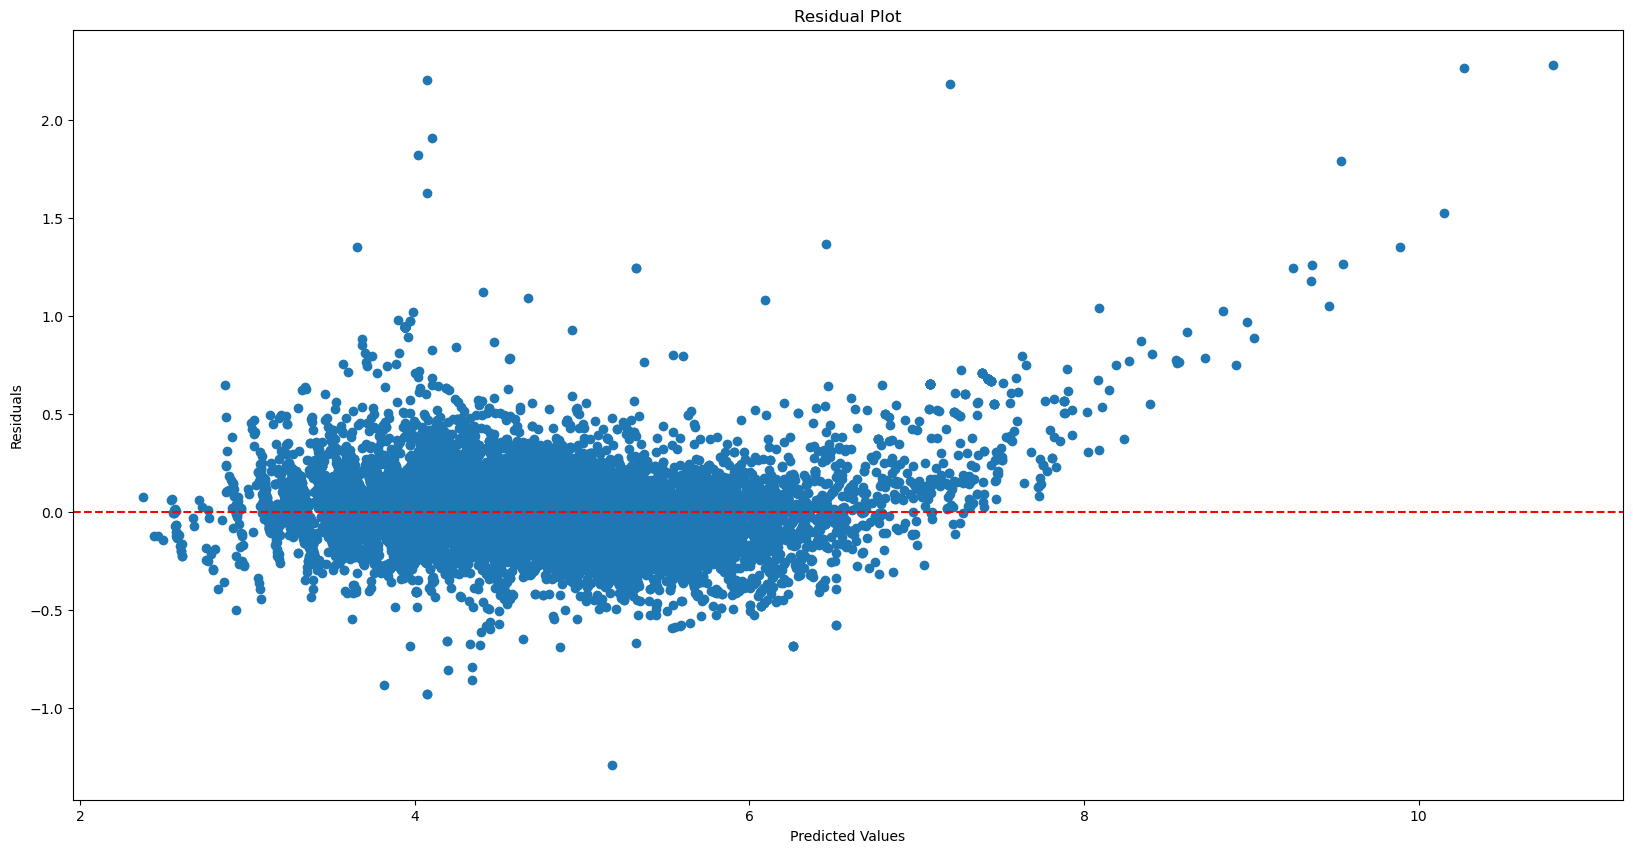

In [42]:
residuals = y_pred - y_test

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


The residual plot indicates presence of outliers in the data

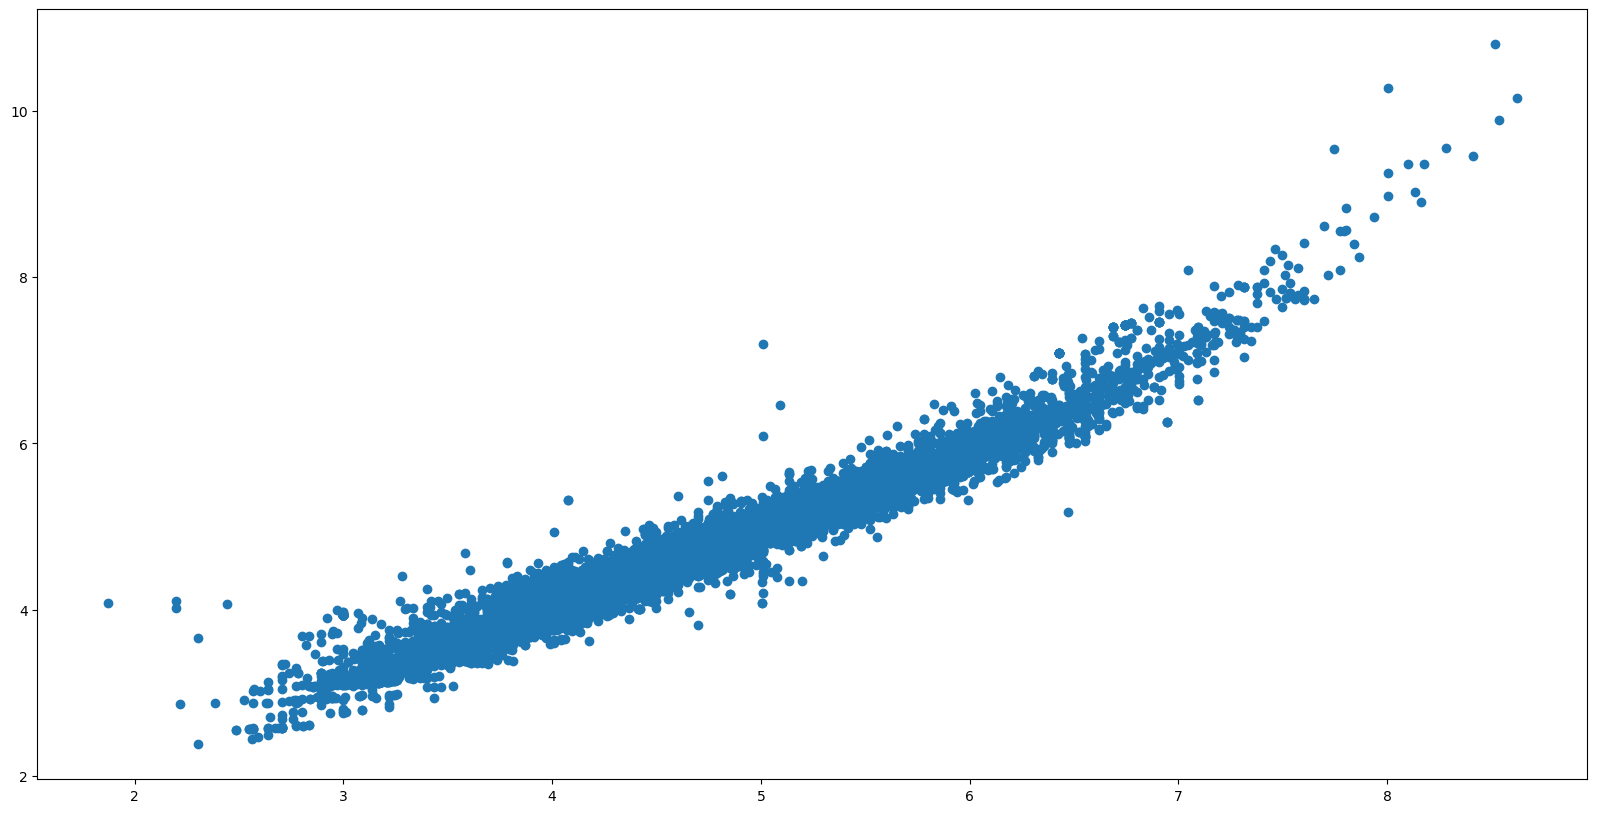

In [43]:
plt.scatter(y_test, y_pred)

Since the points cluster around the diagonal line, it indicates that the model is making reasonably accurate predictions. This is further supported by the distribution plot where the residuals are centered around 0.

/tmp/ipykernel_20/681184782.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - y_pred))


<Axes: xlabel='price_lakhs', ylabel='Density'>

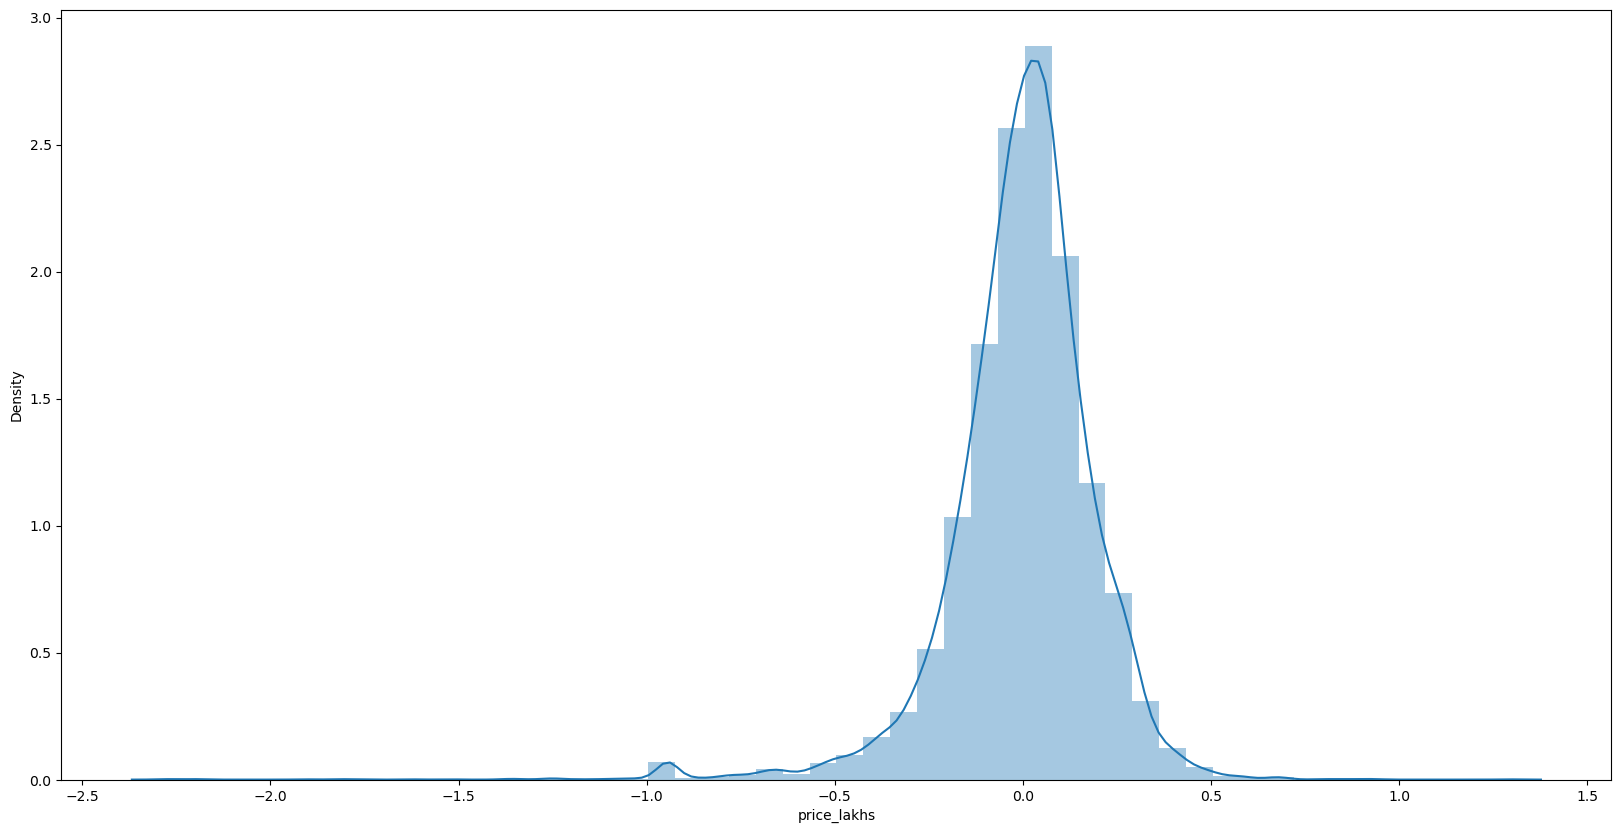

In [44]:
sns.distplot((y_test - y_pred))

Let us see the coefficients of our predictors

In [45]:
cdf = pd.DataFrame(data = lr.coef_, index = X.columns, columns = ['Coefficients'])
cdf

,Coefficients
bhk,2.370324e-01
area,2.555575e-01
price_per_sqft,3.597419e-01
type_Apartment,1.577026e+11
type_Independent House,1.577026e+11
...,...
region_Virar,-2.702540e+10
region_Virar West,-2.702540e+10
region_Wadala,-2.702540e+10
region_Worli,-2.702540e+10


<h3>Further Evaluating the model using RMSE and R2

In [46]:
print('Price mean:', np.round(np.mean(y), 2))  
print('Price std:', np.round(np.std(y), 2))
print('RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))), 2))
print('R2 score train:', np.round(r2_score(y_train, lr.predict(X_train), multioutput='variance_weighted'), 2))
print('R2 score test:', np.round(r2_score(y_test, lr.predict(X_test), multioutput='variance_weighted'), 2))

Price mean: 4.74
Price std: 0.84
RMSE: 0.19
R2 score train: 0.95
R2 score test: 0.95


In [47]:
print(lr.intercept_)

-130677228832.26793


<h3> K-fold Cross validation

In [48]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.9454809 , 0.94461215, 0.94642429, 0.94465378, 0.94977764])

<h3>Exporting the model to a pickel file

In [49]:
import pickle
with open('mumbai_houses_price_prediction.pickle','wb') as f:
    pickle.dump(lr,f)

Exporting column information that might be useful in future predictions

In [50]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))